# Desafio Data Science Brigade
##### Autor: Luiz Rennó Costa
-------

# 1. Necessary Imports

In [3]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

challenge_folder_path = 'drive/My Drive/DSB_Challenge' # Using mounted Google Drive
image_folder = 'images'

# Creating folder for the code challenge
if 'DSB_Challenge' not in os.getcwd():
  if not os.path.exists(challenge_folder_path):
    os.mkdir(challenge_folder_path)
  os.chdir(challenge_folder_path)

# 2. Downloading data files to Google Drive

In [ ]:
#### Downloading files
base_year = 2016
file_ids = ['1OfxA4FGzR4zOy8KIdPl8cAK5ojsJv-vV', 
            '1FEGbEIhE3WQrkd3iy20b5fBi2xwbakXL', 
            '1KT1N3KrLlfpm_UBRbASk4IBZsS-ij2Q5', 
            '1NGpVRqo9xbvEUSzR9KWOOf4V6GeBc5a7'] # File ids for 2016-2019.zip

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Creating data folders
if not os.path.exists('data'):
  os.makedirs('data')
  for year in [2016, 2017, 2018, 2019]:
    os.makedirs(f'data/{year}')

In [ ]:
# Downloading zip files and extracting to respective folders
for i, file_id in enumerate(file_ids):
  file_path = f'data/{base_year+i}/{base_year+i}.zip'
  file_obj = drive.CreateFile({'id': file_id})
  file_obj.GetContentFile(file_path)

  with zipfile.ZipFile(file_path, "r") as zip_ref:
    zip_ref.extractall(f'data/{base_year+i}')

# 3. Merging Tables for each year
Note: Due to RAM limitations, only one table was merged at a time. Local copy was done to ensure fast and easy access to merged data

In [ ]:
import glob
from tqdm import tqdm
years = [2016, 2017, 2018, 2019]

# Merging tables for different years
if not os.path.exists('data/merged'):
  os.makedirs('data/merged')
files_dict = {}
for y in years:
  csv_files = glob.glob(f'data/{y}/*.csv')
  for f in csv_files:
    filename = os.path.basename(f)[:-4]
    if filename not in files_dict:
      files_dict[filename] = []
    files_dict[filename].append(y)

# For each csv_file:
#   For each year:
#     df_list += pd.read_csv(csv_file)
#   df = pd.concat(df_list)
#   df.save()
extension = '.csv'
merged_dfs = {}
for f in tqdm(files_dict):
  df_list = []
  for year in files_dict[f]:
    csv_filename = f'data/{year}/{f}.csv'
    # In order to reduce 
    df = pd.read_csv(csv_filename, index_col=None, header=0)
    df['year'] = year
    df_list.append(df)
  merged_df = pd.concat(df_list, axis=0, ignore_index=True)
  merged_df.to_pickle(f'data/merged/{f}.pickle') # Saving merged tables to file

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 14%|█▍        | 2/14 [00:13<01:54,  9.50s/it]/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interact

# 4. Text processing (licitacao.txt)

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
# licitacao

filename = 'data/merged/licitacao.pickle'
df_licitacao = pd.read_pickle(filename) # Loading previously merged table
df_licitacao['year'] += 10 # Small correction due to programming error

filename = 'data/merged/item.pickle'
df_item = pd.read_pickle(filename) # Loading previously merged table
df_item['year'] += 10 # Small correction due to programming error

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In order to properly analyse the data, a few preprocessing steps were made that included:

- Removing punctuation
- Lower-casing
- Removing words that hold no meaning when counted (like 'aquisição')
- Removing stopwords
- Stemming words
- Tokenizing

In [ ]:
from nltk.corpus import stopwords
import string
import re
replace_dict = {
    re.compile('[0-9]'): '',
    # 'material ': 'material_',
    # 'materiais ': 'materiais_',
    'aquisição ': '',
    'registro ': '',
    'município': 'municipal',
    'conforme': '',
    'secretarias': '',
    'secretaria':'',
    'preços': '',
    'preço': '',
    'material': '',
    'materiais': '',
    'ó': 'o',
    'é': 'e',
    'á': 'a',
    'í': 'i',
    'ú': 'u',
    'nº': '',
} # Corpus-specific replace words dictionary and commom special characters

STOPWORDS = set(stopwords.words('portuguese')) # PT-BR Stopwords corpus
stemmer = nltk.stem.RSLPStemmer() # Portuguese-oriented stemmer

df_compras = df_licitacao[df_licitacao['TP_OBJETO'] == 'COM'] # As instructed
# Text preprocessing; lowercasing, punctuation removal, stopword removal, 
# corpus specific words removal
df_compras['DS_OBJETO'] = df_compras['DS_OBJETO'].str.lower()
df_compras['DS_OBJETO'] = df_compras['DS_OBJETO'].str.replace('[{}]'.format(string.punctuation), '')
df_compras['DS_OBJETO'] = df_compras['DS_OBJETO'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
df_compras['DS_OBJETO'] = df_compras['DS_OBJETO'].replace(replace_dict, regex=True)
df_compras['DS_OBJETO'] = df_compras['DS_OBJETO'].str.replace('municipal', '')

# Text tokenization with stemmer
text = df_compras['DS_OBJETO'].apply(nltk.word_tokenize)
df_compras['TOKEN'] = df_compras['DS_OBJETO'].apply(nltk.word_tokenize)
df_compras['TOKEN'] = df_compras['TOKEN'].apply(lambda x: [stemmer.stem(y) for y in x])

df_compras = df_compras[df_compras['VL_LICITACAO'] <= df_compras['VL_LICITACAO'].quantile(0.99)] # Removing >99% outlier

# Creating date-specific columns
df_compras[['DT_ABERTURA', 'DT_HOMOLOGACAO', 'DT_ADJUDICACAO']] = df_compras[['DT_ABERTURA', 'DT_HOMOLOGACAO', 'DT_ADJUDICACAO']].apply(pd.to_datetime, format='%Y-%m-%d', errors='coerce')
df_compras['DT_DELTA_HOMOLOG'] = df_compras['DT_HOMOLOGACAO'] - df_compras['DT_ABERTURA']
df_compras['DT_DELTA_ADJUDIC'] = df_compras['DT_ADJUDICACAO'] - df_compras['DT_HOMOLOGACAO']

We then group the tokens to find their frequency and extract more information from the dataset. Grouping by year and institution.

In [9]:
def token_count(df, N):
  full_list = []  # list containing all words of all texts
  for elmnt in df['TOKEN']:  # loop over lists in df
      full_list += elmnt  # append elements of lists to full list
      if elmnt == 's':
        print(df['DS_OBJETO'])

  val_counts = pd.Series(full_list).value_counts() # make temporary Series to count
  return val_counts.head(N)

val_counts = df_compras.groupby('year').apply(token_count, 50)
val_counts_institution = df_compras.groupby('NM_ORGAO').apply(token_count,50)

## 4a. Grouping by Institution

Simply checking the most frequent tokens we can see that maintenance-related ones are the most common, most likely related to vehicles (state related ones like patrol cars, garbage-trucks, etc)

In [ ]:
val_counts_institution.nlargest(10)

NM_ORGAO                                         
PM DE GUAPORÉ                            manutenç    1521
PM DE DOM PEDRITO                        compr        650
PM DE PEDRAS ALTAS                       manutenç     616
PM DE NOVA RAMADA                        veicul       571
PM DE PEDRAS ALTAS                       plac         538
PM DE GUAPORÉ                            ativ         516
                                         saud         511
PM DE ERECHIM                            recurs       503
FUND. DE SAÚDE PÚBLICA DE NOVO HAMBURGO  fsnh         478
PM DE PEDRAS ALTAS                       veicul       477
dtype: int64

([<matplotlib.axis.XTick at 0x7f3120f0a470>,
 <a list of 4 Text major ticklabel objects>)

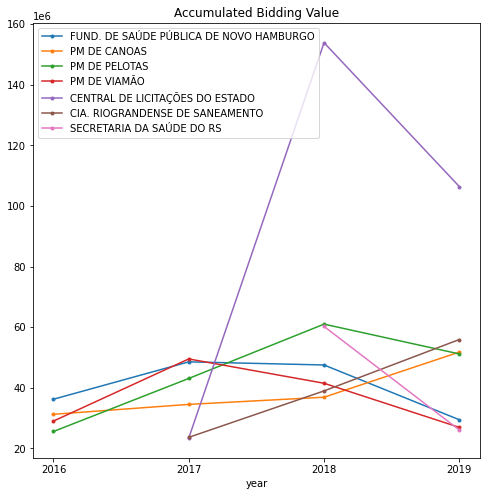

In [ ]:
grouped_biddings = df_compras.groupby(by=['year', 'NM_ORGAO']).apply(lambda df: pd.Series(data=[df['VL_LICITACAO'].sum()], index=['VL_LICITACAO_SUM']))
biggest_agencies = grouped_biddings.sort_values('VL_LICITACAO_SUM', ascending=False).head(10).reset_index()['NM_ORGAO'].unique()
grouped_biddings_reseted = grouped_biddings.reset_index()
grouped_biddings_reseted = grouped_biddings_reseted[grouped_biddings_reseted['NM_ORGAO'].isin(biggest_agencies)]

fig, ax = plt.subplots()
grouped_biddings_reseted.groupby('NM_ORGAO', sort=False).plot(x='year', y='VL_LICITACAO_SUM', sharex=True, ax=ax, style='.-', figsize=(8,8))
plt.legend(grouped_biddings_reseted['NM_ORGAO'].unique())
plt.ticklabel_format(style='sci', scilimits=(6,6), axis='y')
plt.title('Accumulated Bidding Value')
plt.xticks(ticks=[2016, 2017, 2018, 2019])


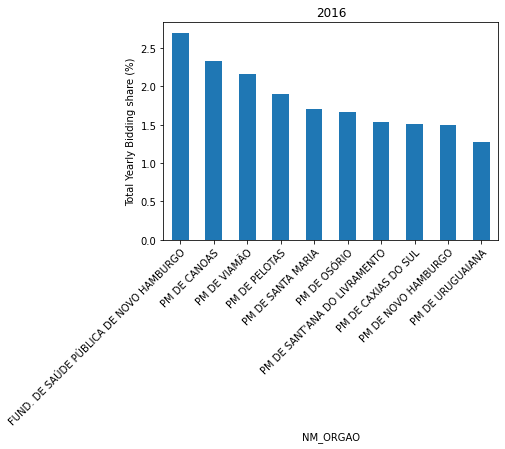

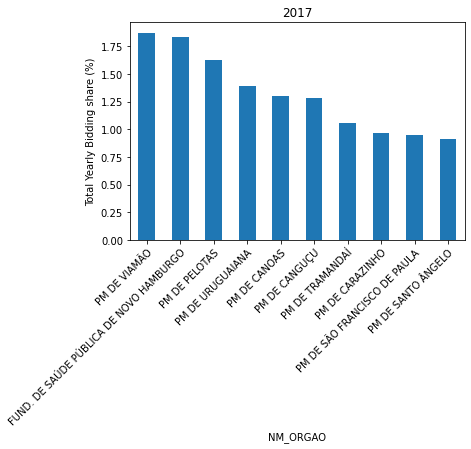

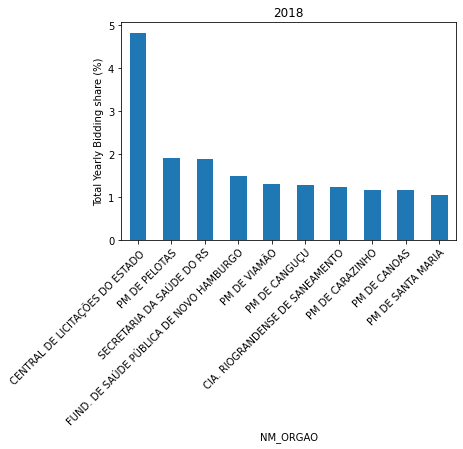

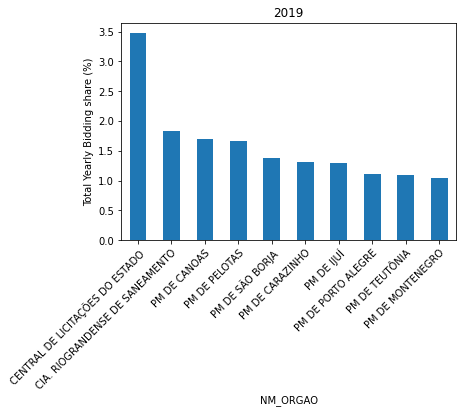

In [ ]:
# Checking bidding share per public institution and year.
def calculate_share_bidding(df):
  df['VL_LICITACAO_SUM_YEAR'] = df['VL_LICITACAO_SUM'].sum()
  df['VL_LICITACAO_SHARE'] = df['VL_LICITACAO_SUM'] * 100.0 / df['VL_LICITACAO_SUM_YEAR']
  return df

grouped_biddings = grouped_biddings.groupby('year').apply(calculate_share_bidding)
biggest_bidding_share = grouped_biddings.groupby('year')['VL_LICITACAO_SHARE'].nlargest(10)
for year, series in biggest_bidding_share.reset_index(level=0, drop=True).groupby('year'):
  plt.figure()
  series.reset_index(level=0, drop=True).plot(kind='bar')
  plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
  plt.ylabel('Total Yearly Bidding share (%)')
  plt.title(year)

## 4b. Grouping By Year

Grouping by year shows that the most important topics are related to public schooling and health. In third place, vehicle-related licitations appear, which act as a reinforcement for the earlier analysis by institution.

([<matplotlib.axis.XTick at 0x7f40a1fee5c0>,
 <a list of 4 Text major ticklabel objects>)

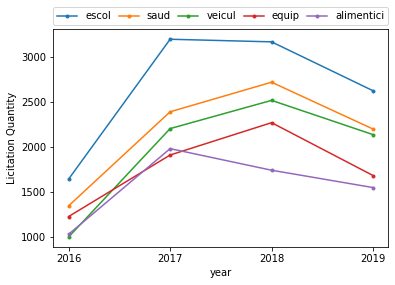

In [10]:
# Veryfing the number of licitations by year
val_counts_unstacked = val_counts.unstack().dropna(axis=1)
val_counts_unstacked.loc['sum'] = val_counts_unstacked.sum(axis=0)

N = 5
N_largest_categories = val_counts_unstacked.loc['sum'].sort_values(ascending=False).head(N).index.tolist()

val_counts_unstacked.drop(labels='sum')[N_largest_categories].plot(style='.-')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=5, mode="expand", borderaxespad=0.)
plt.ylabel('Licitation Quantity')
plt.xticks(ticks=[2016, 2017, 2018, 2019])

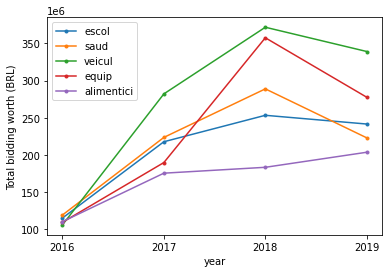

In [ ]:
# Verifying the amount in BRL of licitations per year
N = 5
N_largest_categories = val_counts_unstacked.loc['sum'].sort_values(ascending=False).head(N).index.tolist()
best_tokens = N_largest_categories
def vl_licitacao_sum(df, best_tokens):
  data_dict = {}
  for token in best_tokens:
    df_ = df[df["DS_OBJETO"].str.contains(token)]
    sum_vl = df_['VL_LICITACAO'].sum()
    data_dict[token] = sum_vl

  return pd.Series(data_dict)

licitacao_sum_year = df_compras.groupby('year').apply(vl_licitacao_sum, best_tokens)
licitacao_sum_year.plot.line(style='.-')
plt.ylabel('Total bidding worth (BRL)')
plt.xticks(ticks=[2016, 2017, 2018, 2019])
plt.ticklabel_format(style='sci', scilimits=(6,6), axis='y')


# 5. Election Date analysis

This is a hypothesis check to see if the election dates affect the ammount of biddings or their value.
This was done by using a rolling windows with fixed length of 30 days and calculating both the amount of biddings and their mean value.

Text(0, 0.5, 'Rolling Window (30D) Licitation Count')

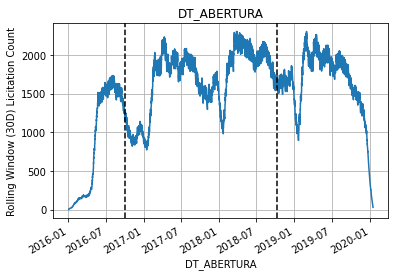

In [ ]:
# Checking to see if the amount of biddings changes when getting closer
# To election dates
df_compras_rolling = df_compras.copy()
df_compras_rolling['DUMMY'] = 1
df_compras_rolling = df_compras_rolling[~df_compras_rolling['DT_ABERTURA'].isna()]
df_compras_rolling = df_compras_rolling[df_compras_rolling['DT_ABERTURA'] > '2016-01-01'] # Removing old 
df_compras_rolling.index = pd.to_datetime(df_compras_rolling['DT_ABERTURA'])

df_compras_rolling = df_compras_rolling.sort_index()
df_compras_rolling['DUMMY'].rolling('30D').count().plot()
election_days = ['2016-10-02', '2018-10-07']

# Highlighting election days
for day in election_days:
  plt.axvline(day, color='k', linestyle='--')
plt.grid('on')
plt.title('DT_ABERTURA')
plt.ylabel('Rolling Window (30D) Licitation Count')

Text(0, 0.5, 'Mean Homologation Time (30D Rolling Window) ')

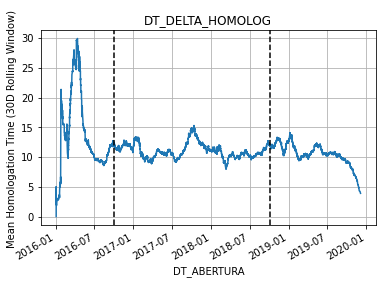

In [ ]:
# Checking to see if the delay between bidding opening and homologation
# is affected by the election date
df_compras_rolling = df_compras.copy()
df_compras_rolling['DUMMY'] = 1
df_compras_rolling = df_compras_rolling[~df_compras_rolling['DT_DELTA_HOMOLOG'].isna()]
df_compras_rolling = df_compras_rolling[df_compras_rolling['DT_ABERTURA'] > '2016-01-01']
df_compras_rolling.index = pd.to_datetime(df_compras_rolling['DT_ABERTURA'])

df_compras_rolling = df_compras_rolling.sort_index()
df_compras_rolling['DT_DELTA_HOMOLOG'].dt.days.rolling('30D').mean().plot()
election_days = ['2016-10-02', '2018-10-07']
for day in election_days:
  plt.axvline(day, color='k', linestyle='--')
plt.grid('on')
plt.title('DT_DELTA_HOMOLOG')
plt.ylabel('Mean Homologation Time (30D Rolling Window) ')

Text(0, 0.5, 'Mean Bidding Value (30D Rolling Window) ')

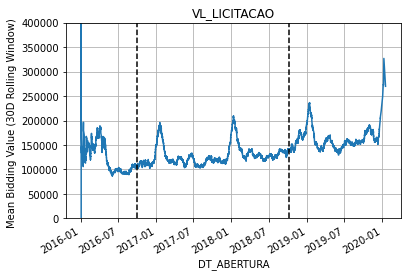

In [ ]:
# Checking to see if the election dates have an impact on bidding value
df_compras_rolling = df_compras.copy()
df_compras_rolling['DUMMY'] = 1
df_compras_rolling = df_compras_rolling[~df_compras_rolling['VL_LICITACAO'].isna()]
df_compras_rolling = df_compras_rolling[df_compras_rolling['DT_ABERTURA'] > '2016-01-01']
df_compras_rolling.index = pd.to_datetime(df_compras_rolling['DT_ABERTURA'])

df_compras_rolling = df_compras_rolling.sort_index()
df_compras_rolling['VL_LICITACAO'].rolling('30D').mean().plot()
election_days = ['2016-10-02', '2018-10-07']
for day in election_days:
  plt.axvline(day, color='k', linestyle='--')
plt.grid('on')
plt.title('VL_LICITACAO')
plt.ylim([0, 400000])
plt.ylabel('Mean Bidding Value (30D Rolling Window)')

Unfortunately, no analysis regarding the election date yielded any interesting results apart from the expected sazonality of the data. When reaching the end of the year, as a multitude of people get off work due to holidays, public licitations also take a hit, only to sharply rise again after the beginnnig of the year

# 6. Analysing homologation delay

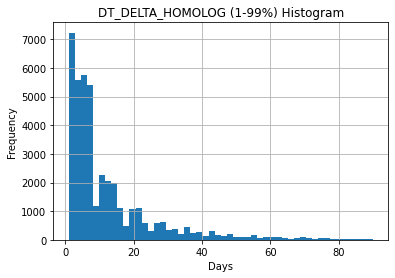

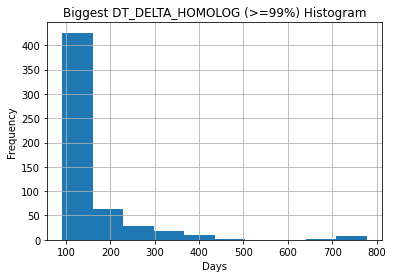

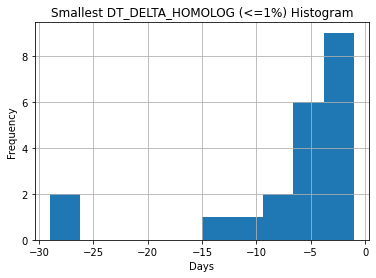

In [ ]:
# Checking 
def plot_histogram_tails(df, column):

  df[(df[column].dt.days < df[column].dt.days.quantile(0.99)) & (df[column].dt.days > df[column].dt.days.quantile(0.01))][column].dt.days.hist(bins=50)
  plt.title(f'{column} (1-99%) Histogram')
  plt.ylabel('Frequency')
  plt.xlabel('Days')

  plt.figure()
  df[df[column].dt.days > df[column].dt.days.quantile(0.99)][column].dt.days.hist(bins=10)
  plt.title(f'Biggest {column} (>=99%) Histogram')
  plt.ylabel('Frequency')
  plt.xlabel('Days')

  plt.figure()
  df[df[column].dt.days < df[column].dt.days.quantile(0.01)][column].dt.days.hist(bins=10)
  plt.title(f'Smallest {column} (<=1%) Histogram')
  plt.ylabel('Frequency')
  plt.xlabel('Days')

plot_histogram_tails(df_compras, 'DT_DELTA_HOMOLOG')

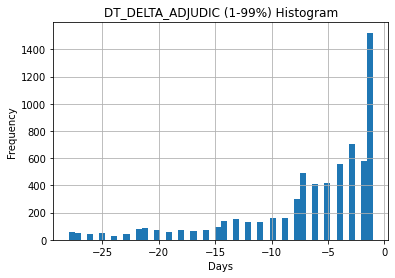

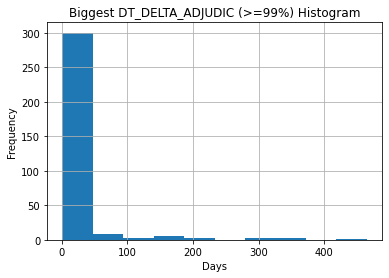

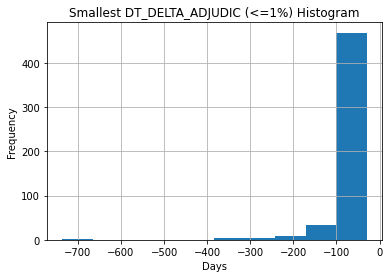

In [ ]:
plot_histogram_tails(df_compras, 'DT_DELTA_ADJUDIC')

# 7. Analysing homologated and empty licitations

In [ ]:
def calculate_total_approval(df):
  df['VL_TOTAL_HOMOLOGADO'] = df['VL_TOTAL_HOMOLOGADO'].astype(float).sum()
  return df.iloc[0]

relevant_columns = ['CD_ORGAO','NM_ORGAO', 'NR_LICITACAO', 'CD_TIPO_MODALIDADE', 'ANO_LICITACAO', 'VL_LICITACAO', 'DT_ABERTURA', 'DT_HOMOLOGACAO']
df_empty_bidding = df_compras[((df_compras['VL_LICITACAO'] == 0) | (df_compras['VL_LICITACAO'].isna())) & (~df_compras['DT_HOMOLOGACAO'].isna())][relevant_columns]
df_empty_bidding_merged = df_empty_bidding.merge(df_item[['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE', 'VL_UNITARIO_HOMOLOGADO','VL_TOTAL_HOMOLOGADO', 'VL_UNITARIO_ESTIMADO','VL_TOTAL_ESTIMADO','DS_ITEM']], how='left', left_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'], right_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'])

df_empty_bidding_merged = df_empty_bidding_merged.groupby(by=['NM_ORGAO', 'NR_LICITACAO', 'CD_TIPO_MODALIDADE', 'ANO_LICITACAO'])[['VL_LICITACAO', 'DT_ABERTURA', 'DT_HOMOLOGACAO', 'VL_TOTAL_HOMOLOGADO']].apply(calculate_total_approval).sort_values(by='VL_TOTAL_HOMOLOGADO', ascending=False)

VL_LICITACAO  ... VL_TOTAL_HOMOLOGADO
NM_ORGAO                  NR_LICITACAO CD_TIPO_MODALIDADE ANO_LICITACAO                ...                    
PM DE RIO GRANDE          42.0         PRE                2019                    0.0  ...          34126500.0
                          10.0         PRP                2018                    0.0  ...          21508000.0
                          12.0         PRP                2017                    0.0  ...          18871000.0
PM DE SAPUCAIA DO SUL     13.0         PRE                2017                    0.0  ...          17762962.0
PM DE RIO GRANDE          9.0          PRE                2017                    0.0  ...          17229561.2
...                                                                               ...  ...                 ...
PM DE ILÓPOLIS            52.0         PRD                2018                    0.0  ...                 0.0
PM DE IPIRANGA DO SUL     6.0          PRD                2017                    0.0  ...                 0.0
                                                          2018                    0.0  ...                 0.0
PM DE ITATIBA DO SUL      1.0          CNV                2017                    0.0  ...                 0.0
SECRETARIA DA SAÚDE DO RS 1237.0       PDE                2018                    0.0  ...                 0.0

[3760 rows x 4 columns]

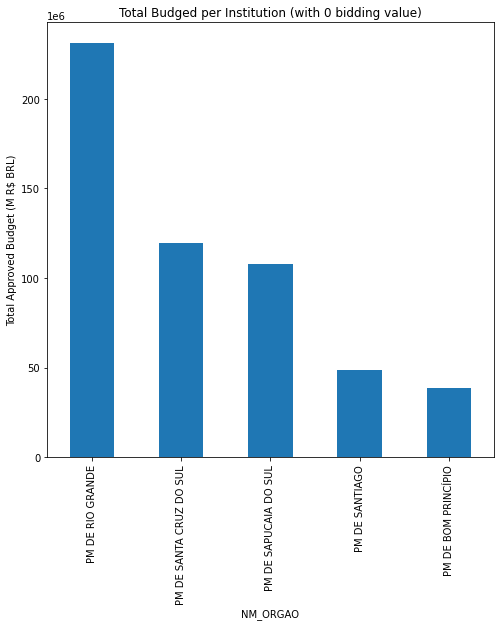

In [ ]:
df_empty_bidding_merged.groupby('NM_ORGAO')['VL_TOTAL_HOMOLOGADO'].apply(np.sum).nlargest(5).plot.bar(figsize=(8,8))
plt.ylabel('Total Approved Budget (M R$ BRL)')
plt.title('Total Budged per Institution (with 0 bidding value)')
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
df_empty_bidding_merged

# 8. Analyses with item information (item.txt)

Looking at the manual, we find that the unique key that combines both tables is a aggregation of  ['CD_ORGAO', 'NR_LICITACAO', 'ANO_LICITACAO'].

In [11]:
df_compras_lite = df_compras[['CD_ORGAO', 'NM_ORGAO','DS_OBJETO', 'VL_LICITACAO', 'NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE', 'TOKEN', 'DT_ABERTURA', 'DT_HOMOLOGACAO', 'DT_ADJUDICACAO']]


df_merged = df_compras_lite.merge(df_item[['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE', 'VL_UNITARIO_HOMOLOGADO','VL_TOTAL_HOMOLOGADO', 'VL_UNITARIO_ESTIMADO','VL_TOTAL_ESTIMADO','DS_ITEM']], how='left', left_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'], right_on=['CD_ORGAO','NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'])
df_merged.head()

,CD_ORGAO,NM_ORGAO,DS_OBJETO,VL_LICITACAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,TOKEN,DT_ABERTURA,DT_HOMOLOGACAO,DT_ADJUDICACAO,VL_UNITARIO_HOMOLOGADO,VL_TOTAL_HOMOLOGADO,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,DS_ITEM
0,84100,PM DE ESPERANÇA DO SUL,merenda escolar,11216.5,4.0,2016,CNV,"[merend, escol]",2016-01-22,2016-01-29,2016-01-29,5.00,360,6.5,468.0,Biscoito doce maria pacote de 700 gramas
1,84100,PM DE ESPERANÇA DO SUL,merenda escolar,11216.5,4.0,2016,CNV,"[merend, escol]",2016-01-22,2016-01-29,2016-01-29,3.61,259.92,4.0,288.0,Biscoito salgado pacote de 400 gramas
2,84100,PM DE ESPERANÇA DO SUL,merenda escolar,11216.5,4.0,2016,CNV,"[merend, escol]",2016-01-22,2016-01-29,2016-01-29,8.58,34.32,9.0,36.0,Farinha de trigo pacote de 5kg
3,84100,PM DE ESPERANÇA DO SUL,merenda escolar,11216.5,4.0,2016,CNV,"[merend, escol]",2016-01-22,2016-01-29,2016-01-29,12.35,49.4,16.5,66.0,Açúcar cristal pacote de 5kg
4,84100,PM DE ESPERANÇA DO SUL,merenda escolar,11216.5,4.0,2016,CNV,"[merend, escol]",2016-01-22,2016-01-29,2016-01-29,3.61,216.6,4.0,240.0,Biscoito salgado pacote de 400 gramas


## 8a. Checking discrepancies

Trying to find just how much is changed between estimated values and actually reported values for the licitations

In [ ]:
def check_discrepancies(df, columns = None):
   df['VL_TOTAL_ESTIMADO_SUM'] = df['VL_TOTAL_ESTIMADO'].sum()  	
   df['DELTA_LICITACAO'] = df['VL_LICITACAO'] - df['VL_TOTAL_ESTIMADO_SUM']
   if not columns:
     columns = ['NM_ORGAO', 'TOKEN', 'VL_LICITACAO', 'DELTA_LICITACAO', 
                'VL_TOTAL_ESTIMADO_SUM', 'DS_OBJETO', 'DT_ABERTURA',
                'DT_HOMOLOGACAO', 'DT_ADJUDICACAO']
   first_row = df.iloc[0]
   return first_row[columns]

keys = ['CD_ORGAO', 'NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE'] 
discrepancies = df_merged.groupby(by=keys).apply(check_discrepancies)

A discrepancy is relevant when the difference between the estimated value (VL_TOTAL_ESTIMADO_SUM) and total budgeted value (VL_LICITACAO) is higher than 10% of the total budget.

In [ ]:
discrepancies[discrepancies['DELTA_LICITACAO'] > 10/100 * discrepancies['VL_LICITACAO']].reset_index(level=0, drop=True).groupby('NM_ORGAO').count().sort_values(by='DS_OBJETO', ascending=False)

,TOKEN,VL_LICITACAO,DELTA_LICITACAO,VL_TOTAL_ESTIMADO_SUM,TOKEN,DS_OBJETO,DT_ABERTURA,DT_HOMOLOGACAO,DT_ADJUDICACAO
NM_ORGAO,,,,,,,,,
PM DE FLORES DA CUNHA,171,171,171,171,171,171,171,149,149
BANCO DO ESTADO DO RIO GRANDE DO SUL S.A.,167,167,167,167,167,167,167,167,167
PM DE FORQUETINHA,115,115,115,115,115,115,115,102,102
CIA. CARRIS PORTO-ALEGRENSE,104,104,104,104,104,104,104,104,104
PM DE SÃO MARCOS,90,90,90,90,90,90,90,78,78
...,...,...,...,...,...,...,...,...,...
PM DE PUTINGA,1,1,1,1,1,1,1,1,1
PM DE RONDINHA,1,1,1,1,1,1,1,1,1
PM DE SANTA CRUZ DO SUL,1,1,1,1,1,1,1,1,1


In [ ]:
disc_df = discrepancies[(discrepancies['DELTA_LICITACAO'] > 10/100 * discrepancies['VL_LICITACAO']) & (discrepancies['VL_TOTAL_ESTIMADO_SUM']>0) ].sort_values(by='DELTA_LICITACAO', ascending=False)
token_count(disc_df, 10)
# disc_df.reset_index().apply(token_count, args=(20,))

famili        18
agricult      14
aliment       12
escol         11
alimentici    11
gêner         11
lei            6
anex           5
rural          4
empreend       4
dtype: int64

# 9. Clustering tokens

This analysis tries to cluster words in order to better understand which sections are most important (regarding licitation count and total networth) for the state. 

For instance, the word _equipment_ appears multiple times (as showed in previous graphs), however, that equipment can be related to several different things, one can have refill of military equipment (for police-work) or kitchen equipment, which are two vastly different areas.

So by trying to implemente better algorithms can further enhance our whole analysis and conclusions.

In [ ]:
!pip install -U -q gensim # Necessary library
from gensim.models import Word2Vec

# Defining and training a Word2Vec model
sentences = df_compras['TOKEN'].tolist()
w2v_model = Word2Vec(window=3, size=200, sample=1e-4)
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)


(10151943, 21250560)

In [ ]:
# Most similar words to 'escol' stem
w2v_model.wv.most_similar(positive=['escol'])

[('fundament', 0.8416236042976379),
 ('ensin', 0.8179751038551331),
 ('alun', 0.7896676063537598),
 ('preescol', 0.7483134269714355),
 ('eja', 0.7299150824546814),
 ('aee', 0.7293643951416016),
 ('crech', 0.6995652318000793),
 ('turm', 0.6876547932624817),
 ('pnac', 0.6619021892547607),
 ('dozolin', 0.6607851982116699)]

Vectorizing the model's vectors to create a 'clusterizable' dataset

In [ ]:
w2v_vectors = w2v_model.wv.vectors
w2v_indices = {word: w2v_model.wv.vocab[word].index for word in w2v_model.wv.vocab} 

def vectorize(line): 
    words = []
    for word in line:
        try:
            w2v_idx = w2v_indices[word]
        except KeyError: 
          continue
        words.append(w2v_vectors[w2v_idx])
        if words: 
            words = np.asarray(words)
            min_vec = words.min(axis=0)
            max_vec = words.max(axis=0)
            return np.concatenate((min_vec, max_vec))
        if not words:
            return None 

phrases_vector = df_compras['TOKEN'].apply(vectorize)

## 9a. Clustering using DBSCAN

This is a super simple and standard approach using DBSCAN with cosine distance with next to none hyper-parameter tuning and rather simple visualization, just as a proof of concept (which unfortunately did not work in the slightest)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

dbscan = DBSCAN(metric='cosine', eps=0.1, min_samples=10, n_jobs=-1)
X = np.stack(phrases_vector.dropna().to_numpy())
X = StandardScaler().fit_transform(X)

dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=10, n_jobs=-1, p=None)

In [ ]:
from sklearn import metrics

labels = dbscan.labels_
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

Estimated number of clusters: 598
Estimated number of noise points: 3531


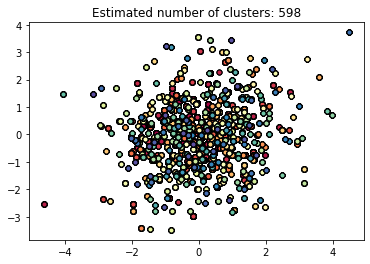

In [ ]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    # xy = X[class_member_mask & ~core_samples_mask]
    # plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #          markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()